# Mining of experimental data

In [1]:
import os
import ast

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.externals import joblib

plt.rcParams['font.size'] = 16
plt.rcParams['axes.facecolor'] = 'white'

# Setting non-interactive backend.
#matplotlib.use('Agg')

%matplotlib inline

In [2]:
def collect_clfs(clf_paths, refs):
    """Read model dumps from disk."""
    
    models = {}
    for num, clf_path in enumerate(clf_paths):
        models[refs[num]] = joblib.load(clf_path) 
        
    return models

In [3]:
def cluster_indices(row_mat, col_mat):
    """Determine row and column indicators for each 
    bicluster."""

    num_biclusters = row_mat.shape[0]

    biclusters = []
    for cluster_num in range(num_biclusters):
        
        rows_bools = row_mat[cluster_num, :] != 0
        cols_bools = col_mat[cluster_num, :] != 0

        rows = [index for index, elt in enumerate(rows_bools) if elt]
        cols = [index for index, elt in enumerate(cols_bools) if elt]

        biclusters.append((rows, cols))

    return biclusters

In [4]:
def gen_graphics(data, title, out_path):
    """Generate a heatmap and save figure to disk."""
    
    plt.figure(figsize=(10, 10))
    plt.title(title)
    sns.heatmap(
        data, robust=True, 
        cmap=plt.cm.RdBu_r, fmt='f', 
        vmin=np.min(data), vmax=np.max(data),
    )
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(out_path)
    
    return None

In [5]:
# NOTE: Pass trained models with rows_ and cols_ attribtues.
def collect_cluster_members(models, references, ref_data):
    """Determine biclsuter row and column indicators, and collect
    bicluster gene and CpG members."""
    
    # Collect bicluster indicators for each detected bicluster.
    biclusters = {}
    for name, model in models.items():
        biclusters[name] = cluster_indices(
            model.rows_, model.columns_
        )
    # Convert cluster indices to cpG and gene labels.
    cluster_members = {}
    # For each class of reference data
    for data_class in references:
        # For each bicluster detected in reference data
        cluster_members[data_class] = {}
        for cluster_num, bicluster in enumerate(biclusters[data_class]):
            # Extract labels by indicator indexing.
            cluster_members[data_class][cluster_num] = {
                'cpgs': list(ref_data[data_class].index[bicluster[0]]),
                'genes': list(ref_data[data_class].columns[bicluster[1]])
            }
            
    return cluster_members

In [6]:
def preds_to_disk(refs, clusters, model, parent='./../predictions/'):
    """Generate txt files containing row and column indicators for 
    detected biclusters associated with different datasets."""
    
    for ref_label in refs:

        stem = '{0}_biclusters_{1}.txt'.format(model, ref_label)
        with open(os.path.join(parent, stem), 'w') as outfile:   
            outfile.write('biclusters_{0}\n'.format(ref_label))

            for cluster_num, coords in clusters[ref_label].items():
                outfile.write('cluster_num_{0}\n'.format(cluster_num))
                outfile.write('{0}\n'.format(coords['cpgs']))
                outfile.write('{0}\n'.format(coords['genes']))
    
    return None

In [7]:
ref_labels = [
    'orig_pvalues', 'sel_pvalues','orig_pcc', 'sel_pcc'
]
# Read experimental data
ref_data = {
    ref_labels[0]: pd.read_csv(
        './../data/train/orig_pvalues_prep.csv', sep=',', index_col=0
    ),
    # NOTE: Transposing to original shape.
    ref_labels[1]: pd.read_csv(
        './../data/train/sel_pvalues_prep.csv', sep=',', index_col=0
    ).T,
    ref_labels[2]: pd.read_csv(
        './../data/train/orig_pcc_prep.csv', sep=',', index_col=0
    ),
    # NOTE: Transposing to original shape.
    ref_labels[3]: pd.read_csv(
        './../data/train/sel_pcc_prep.csv', sep=',', index_col=0
    ).T,
}

## Clustering reference data

Applying the selected biclustering algorithms to the reference data, reconstructing and visualizing the results, selecting the bicluster members and writing the results to disk.

### Source: scikit-learn

In [8]:
# Collect pickled scikit-learn models
sk_clf_paths = [
    './../model_dumps/sk_orig_prep_pvalues.pkl',
    './../model_dumps/sk_sel_prep_pvalues.pkl',
    './../model_dumps/sk_orig_prep_pcc.pkl',
    './../model_dumps/sk_sel_prep_pcc.pkl',
]
sk_clfs = collect_clfs(sk_clf_paths, ref_labels)

In [25]:
# NOTE: Chaning n_clusters param of a model
# sk_clfs['orig_pcc'].n_clusters = 5

In [9]:
# Fit model to data producing bicluster estimates.
for num, (_, model) in enumerate(sk_clfs.items()):
    # NOTE: Ref data is <dict> (converting to <DataFrame>)
    model.fit(list(ref_data.values())[num])

In [10]:
# Reconstruct data matrices by sorting data according to
# predicted biclusters.
reconstr_data = {}
for ref_class in ref_labels:
    # Extract fitted model
    model = sk_clfs[ref_class]
    # Sort reference data
    _data = ref_data[ref_class].values
    _fit_data = _data[np.argsort(model.row_labels_)]
    _sorted_col_ids = np.argsort(model.column_labels_)
    reconstr_data[ref_class] = _fit_data[:, _sorted_col_ids]

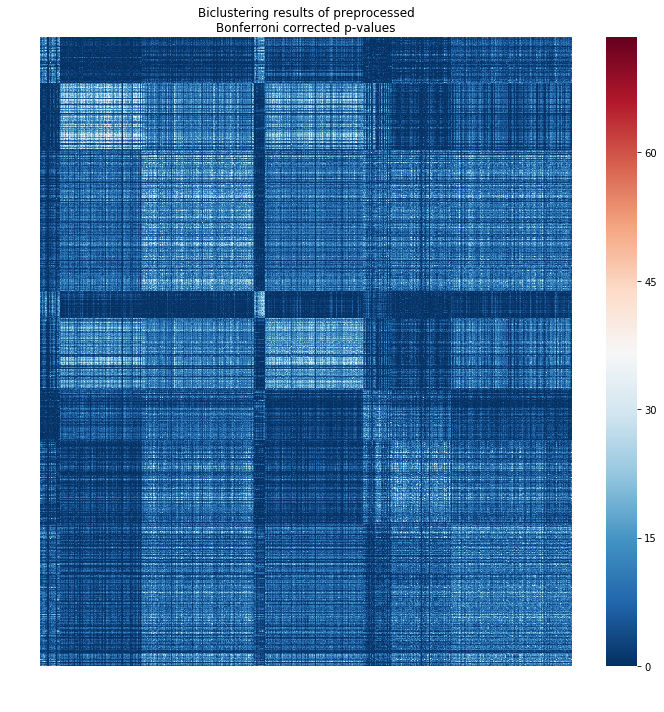

In [11]:
gen_graphics(
    reconstr_data[ref_labels[0]],
    'Biclustering results of preprocessed\n'
    'Bonferroni corrected p-values', 
    './../predictions/imgs/org_prep_pvalues.png'
)

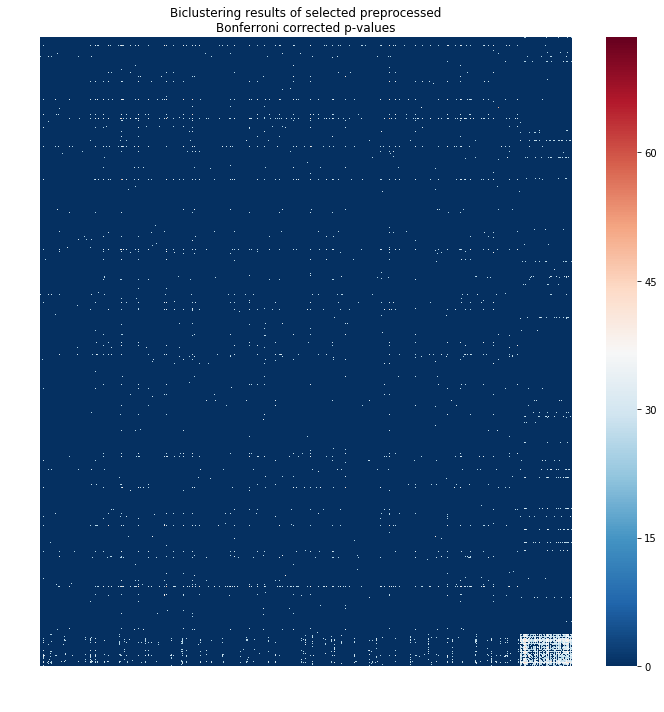

In [12]:
gen_graphics(
    reconstr_data[ref_labels[1]],
    'Biclustering results of selected preprocessed\n'
    'Bonferroni corrected p-values', 
    './../predictions/imgs/sel_prep_pvalues.png'
)

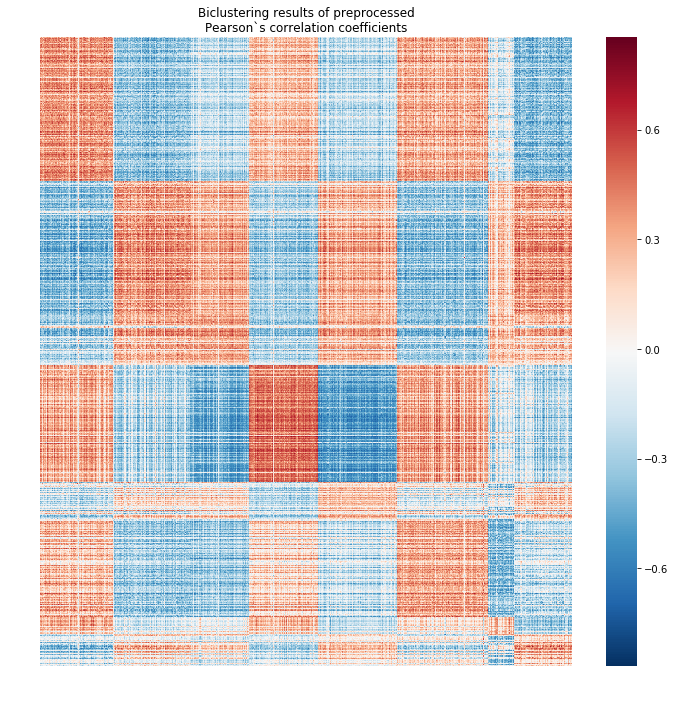

In [13]:
gen_graphics(
    reconstr_data[ref_labels[2]],
    'Biclustering results of preprocessed\n'
    'Pearson`s correlation coefficients', 
    './../predictions/imgs/org_prep_pcc.png'
)

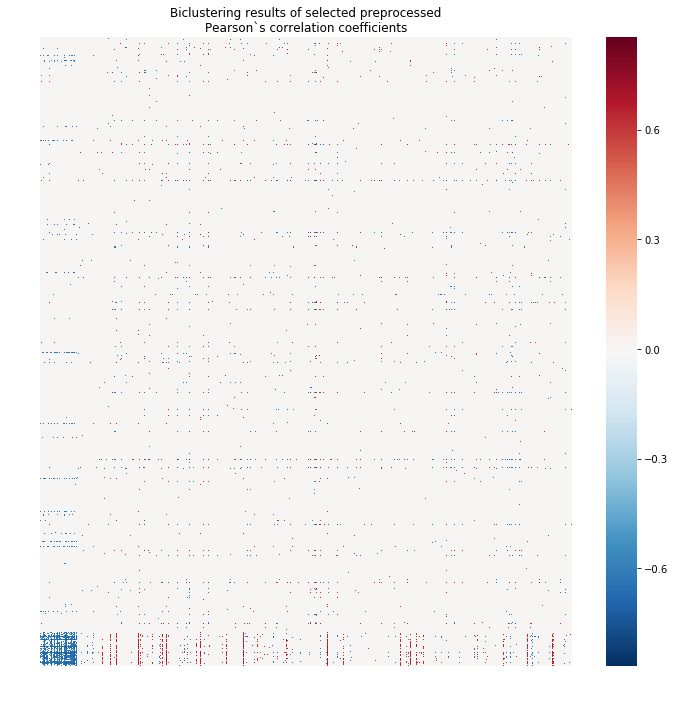

In [14]:
gen_graphics(
    reconstr_data[ref_labels[3]],
    'Biclustering results of selected preprocessed\n'
    'Pearson`s correlation coefficients', 
    './../predictions/imgs/sel_prep_pcc.png'
)

In [15]:
# Fetch bicluster indicators for each detected bicluster
# stored as attributes in fitted models.
sk_biclusters_ = {}
for name, model in sk_clfs.items():
    sk_biclusters_[name] = cluster_indices(
        model.rows_, model.columns_
    )

In [16]:
# Convert cluster indices to cpG and gene labels for each class 
# of reference data, and write results to disk.
sk_cluster_members = collect_cluster_members(
    sk_clfs, ref_labels, ref_data
)
preds_to_disk(ref_labels, sk_cluster_members, model='sk')

### Source: R

In [18]:
# Collect pickled R models

r_clf_paths = [
    './../model_dumps/r_orig_prep_pvalues.pkl',
    './../model_dumps/r_sel_prep_pvalues.pkl',
    './../model_dumps/r_orig_prep_pcc.pkl',
    './../model_dumps/r_sel_prep_pcc.pkl',
]

r_clfs = collect_clfs(r_clf_paths, ref_labels)

In [ ]:
# Fit model to data producing cluster estiamtes.
for num, (_, model) in enumerate(r_clfs.items()):
    # NOTE: Ref data is <dict> (converting to <ndarray>)
    model.fit(list(ref_data.values())[num].values)

In [ ]:
# TODO: Visualizing results (use R tools)

In [ ]:
# Convert cluster indices to cpG and gene labels for each class 
# of reference data, and write results to disk.
r_cluster_members = collect_cluster_members(
    r_clfs, references, ref_data
)

preds_to_disk(references, r_cluster_members, model='r')

### Source: Binary

## Enrichment analysis

In [ ]:
# TODO: Checkout BiBench